# Evaluation of IMERG precipitation estimates

This notebook demonstrates how to use the ``satrain.evaluation.Evaluator`` class to evaluate the accuracy of IMERG Final V07B precipitation estimates using the test data from the SPR dataset.

## The ``satrain.evaluation.Evaluator`` class

The ``satrain.evaluation.Evaluator`` provides functionality to evaluate the accuracy of precipitation retrievals. The two main tasks that the ``Evaluator`` takes care of are 
 1. loading the retrieval input data from the evaluation dataset in the format required for the retrieval and
 2. comparing the results provided by the retrieval to the reference estimates.

In order to make the ``Evaluator`` class applicable to any precipitation retrieval, the retrieval implementation is hidden behind callback function ``retrieval_fn``. The ``Evaluator`` calls this function with the input data from each collocation scene and expects it to return an ``xarray.Dataset`` containing the retrieval results to evaluate.

Evaluating any precipitation retrieval using the SPR dataset, therefore only requires implementing a ``retrieval_fn`` that returns precipitation estimates for the given retrieval input data. Since the retrieval input data contains the spatial and temporal coordinats of the input observations, the evaluator can also be applied to existing precipitation products such as IMERG.

In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
from typing import Tuple

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

To get a better idea of how the retrieval input data that the evaluator passes to the retrieval callback function looks like, we instantiate an evaluator below. In the constructor we specify the reference sensor (``gmi``), the geometry (``gridded`` since the IMERG data is gridded), and the retrieval input data (``[]`` since we don't need any observations or ancillary data). We also use the ``TargetConfig`` class to specify that we want to use a minimum radar-quality index of $0.5$ for the evaluation.

In [2]:
from satrain.target import TargetConfig
from satrain.evaluation import Evaluator

target_config = TargetConfig(min_rqi=0.5)
evaluator = Evaluator(
    domain="conus",
    base_sensor="gmi",
    geometry="gridded",
    retrieval_input=[],
    download=True,
    target_config=target_config
)

Upon instantiation the evaluator takes care of downloading all required data if it isn't already present in the ``satrain`` data path. The length of the evaluator can be used to inspect the number of collocation scenes in the evaluation dataset.

In [3]:
len(evaluator)

2912

The evaluator provides the ``get_input_data`` function, which returns the retrieval input data for a collocation scene identified by its index. This function is helpful for designing and debugging the ``retrieval_fn`` calback function.

In [4]:
input_data = evaluator.get_input_data(0)
input_data

<xarray.Dataset> Size: 6MB
Dimensions:    (latitude: 890, longitude: 854)
Coordinates:
  * latitude   (latitude) float64 7kB 52.0 51.97 51.93 ... 19.74 19.7 19.66
  * longitude  (longitude) float64 7kB -91.98 -91.95 -91.91 ... -60.99 -60.95
Data variables:
    time       (latitude, longitude) datetime64[ns] 6MB 2022-01-01T02:26:00 ....

Since we don't need any input data for evaluating IMERG retrievals, the input data contains only the coordinates of the scene and the nominal time of the MRMS measurements. Note that the time is actually a 2D field because the reference MRMS estimates match the scan time of the PMW observations.

> **Note**: The retrieval will only be evaluated on pixels within the GMI swath. This is to ensure that the retrievals are evaluated on the same data regardless of whether their coverage exteds outside swath of the reference sensor or not.

## Implementing the ``retrieval_fn`` for IMERG precipitation estimates

For the evaluation of the IMERG estimates it is assumed the all IMERG files for the evaluation period (currently July 2023) are located on the local machine.

### Helper functions

We define helper functions to load IMERG data efficiently.


The first function determines the start time of an IMERG file. We will use it to identify the IMERG files that match the time range of each overpass.

In [5]:
IMERG_PATH = Path("/data3/satellite_data/gpm/3b/ms/mrg")

def filename_to_date(path: Path) -> np.datetime64:
    """
    Determine the start time of a IMERG file.

    Args:
        path: A Path object pointing to an IMERG file.

    Return:
        A numpy.datetime64 object representing the start time of the IMERG file.
    """
    path = Path(path)
    parts = path.name.split('.')
    time = pd.to_datetime(parts[4][:16], format="%Y%m%d-S%H%M%S")
    return time.to_datetime64()

imerg_files = sorted(list(IMERG_PATH.glob("**/*.HDF5")))
imerg_files = {filename_to_date(path): path for path in imerg_files}

The second function loads the IMERG surface precipitation and probability of precipitation data into an ``xarray.Dataset``. The function takes the spatial extent of the overpass in order to avoid loading more data than necessary.

In [7]:
def load_imerg_precip(path: Path, bounds: Tuple[float, float, float, float]) -> xr.Dataset:
    """
    Load IMERG precipitation.

    Args:
        path: A Path object pointing to the IMERG file to load.
        bounds: A tuple ``(lon_min, lat_min, lon_max, lat_max)`` defining a bounding box for the data to load.

    Return:
    """
    lon_min, lat_min, lon_max, lat_max = bounds
    with h5py.File(path) as data:
        lons = data["Grid/lon"][:]
        lats = data["Grid/lat"][:]
        lon_mask = np.where((lon_min <= lons) * (lons <= lon_max))[0]
        lon_start, lon_end = lon_mask.min(), lon_mask.max()
        lon_slc = slice(lon_start, lon_end)
        
        lat_mask = np.where((lat_min <= lats) * (lats <= lat_max))[0]
        lat_start, lat_end = lat_mask.min(), lat_mask.max()
        lat_slc = slice(lat_start, lat_end)
        
        surface_precip = data["Grid/precipitation"][0, lon_slc, lat_slc]
        precip_flag = surface_precip > 1e-2
        heavy_precip_flag = surface_precip > 10.0
        lons = lons[lon_start:lon_end]
        lats = lats[lat_start:lat_end]
        time = np.datetime64("1980-01-06") + data["Grid/time"][:].astype("timedelta64[s]")
        
    return xr.Dataset({
        "longitude": (("longitude"), lons),
        "latitude": (("latitude"), lats),
        "surface_precip": (("longitude", "latitude"), surface_precip),
        "precip_flag": (("longitude", "latitude"), precip_flag.astype(np.int8)),
        "heavy_precip_flag": (("longitude", "latitude"), precip_flag.astype(np.int8)),
        "time": time.astype("datetime64[ns]")
    })

## Retrieval callback function

The retrieval callback function should return an xarray.Dataset containing the retrieved surface precipitation rate, probability of precipitation, precipitation flag, probability of heavy precipitation, and a heavy precipitation flag.

 With the helper functions defined, we implement retrieval_fn to load and interpolate IMERG data for given evaluation scenes. The input data provided by the evaluator contains the coordinates of the reference MRMS estimates in the collocation scene and the corresponding timestamps. The function below uses this information to 
 1. load the IMERG data covering the overpass and
 2. interpolate the data to the temporospatial coordinates of the evaluation data.

In [ ]:
def retrieve_imerg(input_data: xr.Dataset) -> xr.Dataset:
    """
    Retrieval callback function to load IMERG data corresponding to SATRAIN SPR evaluation data.

    Args:
        input_data: An xarray.Dataset containing the retrieval input data.
    """
    time_min = np.nanmin(input_data.time.data)
    time_min = time_min.astype("datetime64[h]").astype("datetime64[s]")
    time_max = np.nanmax(input_data.time.data)
    time_max = time_max.astype("datetime64[h]").astype("datetime64[s]") + np.timedelta64(3600, "s")
    lons = input_data.longitude.data
    lats = input_data.latitude.data
    lon_min, lon_max = lons.min(), lons.max()
    lat_min, lat_max = lats.min(), lats.max()
    bounds = (lon_min, lat_min, lon_max, lat_max)
    files = [
        imerg_file for time, imerg_file in imerg_files.items()
        if time_min <= time and time <= time_max
    ]
    imerg_data = xr.concat([load_imerg_precip(path, bounds=bounds) for path in files], "time")
    imerg_data = imerg_data.interp(
        latitude=input_data.latitude,
        longitude=input_data.longitude,
        time=input_data.time,
        method="nearest"
    )
    # Delay conversion to bool since interp ingores bool variables.
    imerg_data["precip_flag"] = imerg_data.precip_flag.astype(bool)
    imerg_data["heavy_precip_flag"] = imerg_data.precip_flag.astype(bool)
    return imerg_data

## Case study

To verify that the retrieval function returns the expected results, the ``evaulator`` provides a ``plot_retrieval_results`` function. As the name suggests, the function uses the ``retrieval_fn`` to obtain the retrieval results for a given scene and the plots them together with the reference precipitation. Here, we will use index 86 because this happens to be a scene with some interesting precipitation features that are reasonably well covered by MRMS measurements.

/home/simon/miniforge3/envs/satrain/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1600: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)


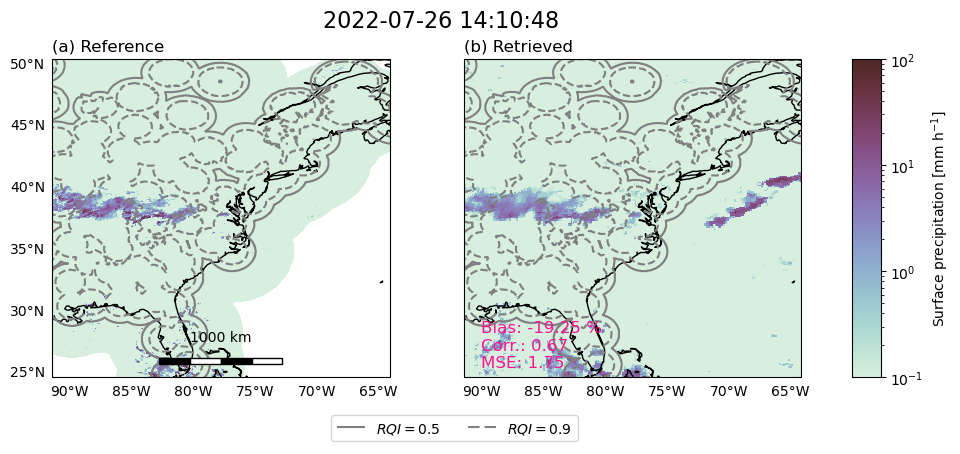

In [42]:
fig = evaluator.plot_retrieval_results(scene_index=1637, retrieval_fn=retrieve_imerg, include_metrics=True)

## Running the evaluator

With the ``retrieval_fn`` callback function setup, the IMERG retrievals can be evaluated on the full evaluation dataset using the evaluator's ``evaluate`` function. This can be done using multiple processes to speed up the process.

In [44]:
from satrain import metrics
evaluator.evaluate(retrieval_fn=retrieve_imerg, n_processes=8)

Output()

# Results

The evaluator evaluates the retrieval on five tasks:
 1. Precipitation quantification (or estimation)
 2. Deterministic precipitation detection
 3. Probabilistic precipitation detection
 2. Deterministic heavy precipitation detection
 3. Probabilistic heavy precipitation detection

 However, since IMERG does not provide any probabilistic detection outputs, the evaluator cannot evaluate the probabilistic detection of precipitation and heavy precipitation. 

## Precipitation quantification

The evaluator computes Bias, mean absolute error (MAE), mean squared error (MSE), symmetric mean absolute percentage error (SMAPE), correlation coefficient, and effective resolution for the precipitation estimates results. The combined results for the precipitation estimation can be obtained using the evaluator's ``get_precip_estimation_results`` function.

The ``get_precip_estimation_results`` function has an aditional keyword argument ``include_baselines``. If ``include_baselines`` is ``True``, results from IMERG V7 and GPROF V7 retrieval are included in the returned results. This is useful when evaluating new retrieval algorithms. However, since this is the notebook where the baseline accuracies are calculated, we set the value to ``False`` for now.

In [46]:
evaluator.get_precip_quantification_results("IMERG Final V7 (GMI)", include_baselines=True)

,Bias [$\%$],MAE [$mm h^{-1}$],MSE [$(mm h^{-1})^2$],SMAPE$_{0.1}$ [$\%$],Correlation coeff. [],Effective resolution [$^\circ$]
IMERG Final V7 (GMI),-4.246338,0.113136,0.984645,123.910083,0.431526,inf
ERA5,-6.411143,0.148941,1.275885,101.513506,0.273334,inf
GPROF V7 (GMI),5.799770,0.119785,1.413339,91.327371,0.552348,0.423


> **Note**: The effective resolution being ``inf`` signifies that the spectral coherence does not reach $\frac{1}{\sqrt{2}}$ within the scales resolved within the window size of the ``SpectralCoherence`` metric which is 48. At a pixel resolution of 0.036 degree, the maximum scale resolved by the spectral coherence is 0.036 * 48 / 2, i.e., 0.864 degree. The effective resolution of IMERG being ``inf`` thus indicates that the effective resolution exceeds 0.864 degree.

## Precipitation detection



Precipitation detection is evaluated using the probability of detection (POD), false-alarm rate (FAR) and Heidke skill score (HSS).
The evaluator provides the ``get_precip_detection_results`` function to display the results from the precipitation detection.

In [47]:
evaluator.get_precip_detection_results("IMERG Final V7 (GMI)", include_baselines=True)

,POD [],FAR [],HSS []
IMERG Final V7 (GMI),0.557637,0.469749,0.493011
ERA5,NaN,NaN,NaN
GPROF V7 (GMI),0.758366,0.462010,0.508161


## Heavy precipitation detection results

The evaluator similarly provides results for heavy precipitation detection using relevant metrics, helping to evaluate performance across different precipitation intensities.

In [48]:
evaluator.get_heavy_precip_detection_results("IMERG Final V7 (GMI)", include_baselines=True)

,POD [],FAR [],HSS []
IMERG Final V7 (GMI),0.900184,0.98428,-0.056934
ERA5,NaN,NaN,NaN
GPROF V7 (GMI),0.758366,0.46201,0.508161
